# DF20 funghi dataset download &#127812;

The DF dataset (Danish Fungi) is an image recognition dataset focused on fungi. It was made from the data from the Atlas of Danish Fungi in 2020.

The dataset is being extended year by year and for the 2024 it consist of 295398 images in the training set. The validation set consists of 30131 images. The dataset is supplemented with a metadata file that contains not only the classes but also additional data such as the location of the observation, the habitat, substrate information and season.

The main benefit of this dataset is its zero overlap with ImageNet data. This allows of unbiased evaluation of models.

The full dataset weights ~110GB in training images. Due to the size the authors also presented a reduced version. The reduced version is about 6.5GB. The reduction is based on maximum edge length. The reduced version is also harder to learn.

# 1. Usage

This notebook is ment to be used as a downloader for the dataset. It should be used from the outside as a module. The dataset is placed int he `data` folder which is created the the current working directory.

To use it please check out the github package or link to your own google drive. Then you can run the notebook from another notebook using the `%run` magic.


In [ ]:
# %run "./drive/MyDrive/Colab Notebooks/DF20_dataset.ipynb"

There are two options that can be set to configure this notebook. The first is `USE_DF20_LARGE` environment variable. It is used to define if the notebook should download the small or the full dataset.

NOTE: at the moment only the small one is supported.

The second option is the `DF20_DWDL_METHOD` that defines the source of the files for the notebook. Currently there are two sources implemented.

| Value | Description |
|---|---|
| GDRIVE | uses the files stored on the Google drive (low quota) |
| MEGA | uses the Mega.nz (.io) drive (slower, more quota) |
| WGET | uses the default repo (czech), slowest |
| **DROPBOX** | uses dropbox as source (preffered) |

The default download method is the WGET due to small amount of issues.

In [ ]:
import os
# override method
#os.environ['DF20_DWDL_METHOD'] = 'GDRIVE'

### 1.1 Helper functions

In [ ]:
import os

In [ ]:
def UseLargeData():
  ''' Returns True if the USE_DF20_LARGE environment variable is set. Otherwise
  returns False.
  '''
  return True if 'USE_DF20_LARGE' in os.environ.keys() else False

def PrintMsg(msg :str):
  print("")
  print(f" ********** {msg} ********** ")
  print("")

In [ ]:
def checkDownloadMethod():
  '''Prints out the download source'''
  return os.getenv('DF20_DWDL_METHOD', 'DROPBOX')


In [ ]:
if UseLargeData():
  PrintMsg('Using LARGE dataset.')
else:
  PrintMsg('Using SMALL dataset.')

PrintMsg(f"File source: {checkDownloadMethod()}")


 ********** Using SMALL dataset. ********** 


 ********** File source: MEGA ********** 



# 2. Build paths

Before downloading the dataset the folders to hold the data are created. Data is hold in the `/data` folder. This folder has two subfolders: `train` for training data and `val` for validation.

In [ ]:
from pathlib import Path

In [ ]:
# save cwd before doing any changes to it.
root_folder = os.getcwd()

In [ ]:
PrintMsg('Creating folders')

base_folder = Path.cwd() / 'data'
base_folder.mkdir(exist_ok=True)

train_folder = base_folder / 'train'
val_folder = base_folder / 'val'
train_folder.mkdir(exist_ok=True)
val_folder.mkdir(exist_ok=True)

print(base_folder)
print(train_folder)
print(val_folder)


 ********** Creating folders ********** 

/content/data
/content/data/train
/content/data/val


# 3. Download

This section downloads and unzips the dataset. Due to colab issues with the direct download from the server I've decided to host the data on my Google drive. This makes the whole process easier.

NOTE: Colab solved the issue and now `!wget` can download the files but it is still way slower than a `!gdown` from Google servers.

NOTE: The proper way of using wget to grab the data from the source is to use the command in the following form:


```
!wget --no-check-certificate "<link to file>"
```
If the " " are ommited the file might not be downloaded in some cases.

Due to limitations in the Google quota the primary storage place is now Mega.io drive. This increases the download time but the Mega.io has approx. 5GB daily quota which is more than enough.
NOTE: Mega.io CLI tools are buggy. Method doesn't work as expected!

The latest distribution idea is to use the Dropbox. Other storages were investigated such as Sync.com or PCloud (has, but paid) but they do not allow direct linking. In fact any service which uses cloud storage without any special adaptation layer will have issues with exposing direct links. Dropbox has this feature ready and works ok.

DEFAULT SOURCE: Dropbox

## 3.1 Required tools

For certain method some special tools need to be installed:
1. Mega.io - requires megacmd, uses ubuntu 22.04 version for Colab

In [ ]:
dwdl_method = checkDownloadMethod()

if dwdl_method == 'MEGA':
  # install mega-get
  !wget https://mega.nz/linux/repo/xUbuntu_22.04/amd64/megacmd-xUbuntu_22.04_amd64.deb --quiet && sudo apt install "$PWD/megacmd-xUbuntu_22.04_amd64.deb" --quiet
  #!rm megacmd-xUbuntu_22.04_amd64.deb

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libc-ares2 libmediainfo0v5 libmms0 libtinyxml2-9 libzen0v5
The following NEW packages will be installed:
  libc-ares2 libmediainfo0v5 libmms0 libtinyxml2-9 libzen0v5 megacmd
0 upgraded, 6 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,457 kB/13.5 MB of archives.
After this operation, 47.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmms0 amd64 0.6.4-3 [27.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtinyxml2-9 amd64 9.0.0+dfsg-3 [32.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libzen0v5 amd64 0.4.39-1 [97.5 kB]
Get:4 /content/megacmd-xUbuntu_22.04_amd64.deb megacmd amd64 1.6.3-2.1 [11.0 MB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmediainfo0v5 amd64 21.09+dfsg-4 [2,255 kB]
Get:6 http://archive.ubuntu.com/ubunt

## 3.1 Metadata

First we grab the metadata CSV file. There are two files. One for train images and one for validation images. Both metadata files are common for the large and the reduced datasets.

The metadata files are imported into the apropriate train / val folders.


In [ ]:
# Grab the files with gdown from my shared drive.
PrintMsg('Downloading metadata')
os.chdir(base_folder)

if dwdl_method == 'GDRIVE':
  !gdown 1C8nWUBrHKzcB1djOOysVQhJTZQ3eoeVq
  !gdown 1CIXpcWG04f23uQEAZAiiQudEPf0GxrbA
elif dwdl_method == 'MEGA':
  !mega-get "https://mega.nz/file/IL0yVTSS#FcCyC6ST3VfRxDVvXzfs796AlyiAcUclwKbpQwW5AVw"
  !mega-get "https://mega.nz/file/8W8ChbwB#20ekpAeJ74Q2-7UJvpXdRTBY5wv_aJfrbnUVOpKlY2k"
elif dwdl_method == 'WGET':
  !wget --no-check-certificate "http://ptak.felk.cvut.cz/plants/DanishFungiDataset/FungiCLEF2023_train_metadata_PRODUCTION.csv"
  !wget --no-check-certificate "http://ptak.felk.cvut.cz/plants/DanishFungiDataset/FungiCLEF2023_val_metadata_PRODUCTION.csv"
else:
  # using DropBox
  # --content-disposition <- używa nazwy sugerowanej przez serwer, inaczej wrzuca key do nazwy
  !wget --content-disposition "https://www.dropbox.com/scl/fi/6u4yw77fmynqs3gjx47mc/FungiCLEF2023_train_metadata_PRODUCTION.csv?rlkey=8a31uwlzfp6d43pewuyv7mwtz&st=g7nqpnes&dl=0"
  !wget --content-disposition "https://www.dropbox.com/scl/fi/d6ax50zobziiqm3dao0l5/FungiCLEF2023_val_metadata_PRODUCTION.csv?rlkey=g9c53xtayo0932muhoijy2lrg&st=rpztgn4k&dl=0"


 ********** Downloading metadata ********** 

[Initiating MEGAcmd server in background. Log: /root/.megaCmd/megacmdserver.log]
[API:err: 06:56:46] Failed to get public node: Not found


Next we check if the metadata file is correctly downloaded by showing the head of val metadata file.

In [3]:
# install pandas (as it is missing on eg. VAST image)
!pip install pandas --quiet

In [ ]:
import pandas as pd
df = pd.read_csv(base_folder / 'FungiCLEF2023_val_metadata_PRODUCTION.csv')
df.head()

,observationID,month,day,countryCode,locality,taxonID,scientificName,kingdom,phylum,class,...,Substrate,Latitude,Longitude,CoorUncert,Habitat,image_path,filename,MetaSubstrate,class_id,poisonous
0,3008834344,1.0,1.0,DK,Kildevænget,15233,Hypoxylon fragiforme (Pers.) J.Kickx f.,Fungi,Ascomycota,Sordariomycetes,...,NaN,55.946963,12.292050,31.0,Deciduous woodland,0-3008834344.JPG,0-3008834344,wood,702,0
1,3008834345,1.0,1.0,DK,Kildevænget,14428,Gymnopilus penetrans (Fr.) Murrill,Fungi,Basidiomycota,Agaricomycetes,...,NaN,55.947665,12.287160,16.0,coniferous woodland/plantation,0-3008834345.JPG,0-3008834345,wood,553,0
2,3008834345,1.0,1.0,DK,Kildevænget,14428,Gymnopilus penetrans (Fr.) Murrill,Fungi,Basidiomycota,Agaricomycetes,...,NaN,55.947665,12.287160,16.0,coniferous woodland/plantation,1-3008834345.JPG,1-3008834345,wood,553,0
3,3008834353,1.0,1.0,DK,"Norup, Vammen",12226,Cordyceps militaris (L.) Link,Fungi,Ascomycota,Sordariomycetes,...,mosses,56.529817,9.550255,30.0,coniferous woodland/plantation,0-3008834353.JPG,0-3008834353,mosses,267,0
4,3008834353,1.0,1.0,DK,"Norup, Vammen",12226,Cordyceps militaris (L.) Link,Fungi,Ascomycota,Sordariomycetes,...,mosses,56.529817,9.550255,30.0,coniferous woodland/plantation,1-3008834353.JPG,1-3008834353,mosses,267,0


## 3.2 Train images

The training data is quite large even in the reduced form. To speed things up the download is done via the private gdrive copy. One of the issues we got is the unpacking of the files. Since tar is not the most user friendly tool, and because we do not want additional installations the checkpoints are used. The checpoint shows the progress of the unpack. Crude but at least there is some indication of the ongoing process.

I would like to thank the authors of tar personally. My opinion on tar is shown on the doodle below (author unknown, found via google):

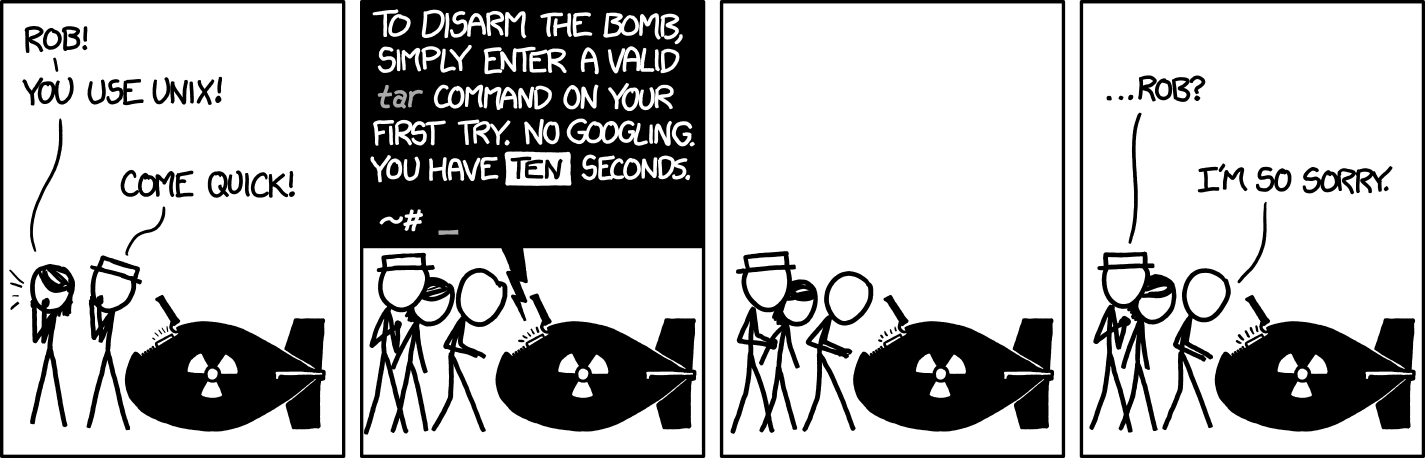

In [ ]:
PrintMsg('Downloading training images')
os.chdir(train_folder)

if UseLargeData():
  raise "Large dataset not supported yet."
else:
  if dwdl_method == 'GDRIVE':
    !gdown 1CEcd2a_qASjNKpf2IIHG4_mhM7a--_Xx
  elif dwdl_method == 'MEGA':
    !mega-get https://mega.nz/file/pDt3RKbS#K4PywHkwcSjOd1J9IYE8BRtWn9I77Nv2EPDFxwRhLb8
  elif dwdl_method == 'WGET':
    !wget --no-check-certificate "http://ptak.felk.cvut.cz/plants/DanishFungiDataset/DF20-300px.tar.gz"
  else:
    !wget --content-disposition "https://www.dropbox.com/scl/fi/xk4q3qd3oidjgqv1qnyjk/DF20-300px.tar.gz?rlkey=elkzqc03ktzc7ng6wdo693ew7&st=lchsmpil&dl=0"


 ********** Downloading training images ********** 


Download finished: /content/data/train/./DF20-300px.tar.gz
TRANSFERRING ||######################################||(6125/6125 MB: 100.00 %)  


In [ ]:
# unpack data
if UseLargeData():
  raise "Large dataset not supported yet."
else:
  !tar -xf ./DF20-300px.tar.gz --checkpoint=50000
  !rm DF20-300px.tar.gz

tar: Read checkpoint 50000
tar: Read checkpoint 100000
tar: Read checkpoint 150000
tar: Read checkpoint 200000
tar: Read checkpoint 250000
tar: Read checkpoint 300000
tar: Read checkpoint 350000
tar: Read checkpoint 400000
tar: Read checkpoint 450000
tar: Read checkpoint 500000
tar: Read checkpoint 550000
tar: Read checkpoint 600000
tar: Read checkpoint 650000


## 3.3 Validation images

In [ ]:
PrintMsg('Downloading validation images')
os.chdir(val_folder)

if UseLargeData():
  raise "Large dataset not supported yet."
else:
  if dwdl_method=='GDRIVE':
    !gdown 1CMN2HOzysnQoYm6eAPqKybzaKs4exYPq
  elif dwdl_method=='MEGA':
    !mega-get https://mega.nz/file/5fE1WR4J#rIFGuk9TqYnyt_1AFL98MmDhAtPYlU2GpYtpfvsF4-A
  elif dwdl_method=='WGET':
    !wget --no-check-certificate "http://ptak.felk.cvut.cz/plants/DanishFungiDataset/DF21_300px.tar.gz"
  else:
    !wget --content-disposition "https://www.dropbox.com/scl/fi/4msnm2sgnchvqq9xf38ay/DF21_300px.tar.gz?rlkey=cmihjalanxc2ii38futjurvo2&st=bbhs68cp&dl=0"


 ********** Downloading validation images ********** 

Downloading...
From (original): https://drive.google.com/uc?id=1CMN2HOzysnQoYm6eAPqKybzaKs4exYPq
From (redirected): https://drive.google.com/uc?id=1CMN2HOzysnQoYm6eAPqKybzaKs4exYPq&confirm=t&uuid=1a3a9a88-afa8-4714-8492-27c5986abb18
To: /content/data/val/DF21_300px.tar.gz
100% 2.81G/2.81G [01:02<00:00, 45.1MB/s]


In [ ]:
# unpack data
if UseLargeData():
  raise "Large dataset not supported yet."
else:
  !tar -xf ./DF21_300px.tar.gz --checkpoint=50000
  !rm DF21_300px.tar.gz

tar: Read checkpoint 50000
tar: Read checkpoint 100000
tar: Read checkpoint 150000
tar: Read checkpoint 200000
tar: Read checkpoint 250000


# 4. Cleanup

Since we made some changes to CWD we must revert it to starting point value.

In [ ]:
# revert cwd
os.chdir(root_folder)

#remove the loaders
if dwdl_method=='MEGA':
  !rm megacmd-xUbuntu_22.04_amd64.deb